In [2]:
# IMPORTS #

# For handeling FITS files
from astropy.io import fits
from scipy import stats
from glob import glob

import numpy as np
from matplotlib import pyplot as plt

In [3]:
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 26})
plt.rcParams["figure.figsize"] = (15,10)

# Example To Make Plot

In [4]:
image = fits.open(r"C:\Users\hollm\OneDrive\Desktop\College\Physics\UCD_PASS_Labs\CCDs\Data_D1\daragh_ccd\bias\bias_01.fit")

In [5]:
print(np.shape(image[0].data))

(100, 100)


In [6]:
total = 0
count=1
for line in image[0].data:
    for el in line:
        total+=el
        count+=1


[[260 250 255 ... 288 241 270]
 [252 263 244 ... 267 258 235]
 [262 270 256 ... 260 260 259]
 ...
 [288 284 266 ... 250 252 258]
 [280 245 264 ... 240 250 237]
 [258 248 224 ... 239 244 244]]


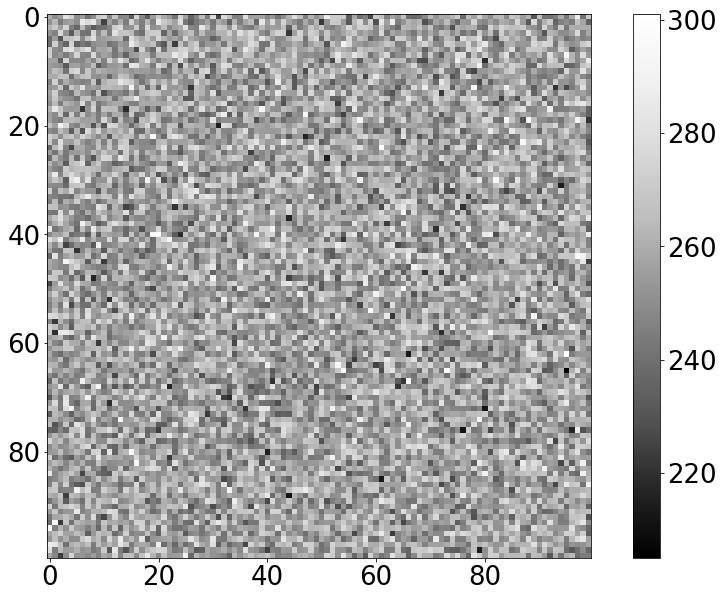

In [7]:
print(image[0].data)
plt.imshow(image[0].data, cmap="Greys_r")
plt.colorbar()

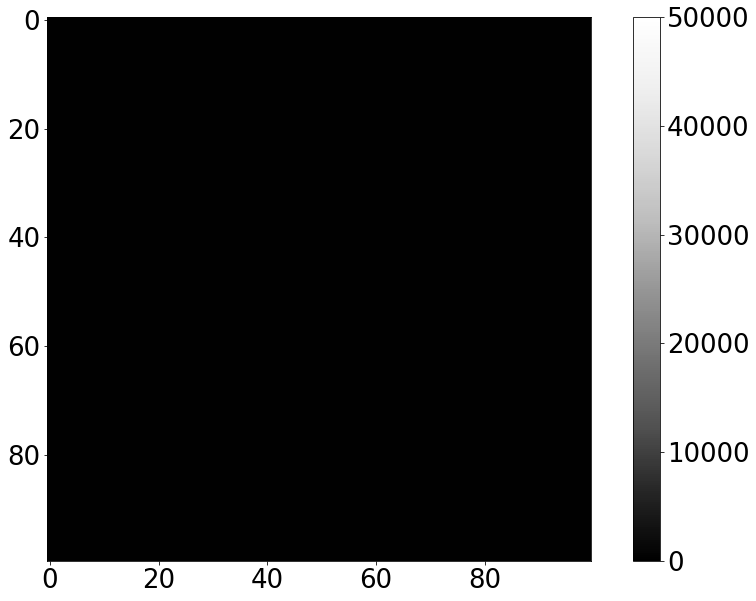

In [8]:
pixel_values = image[0].data
plt.imshow(pixel_values,vmin=0,vmax=50000, cmap="Greys_r")
plt.colorbar()

In [9]:
line_values = image[0].data[800]
print(max(line_values))

IndexError: index 800 is out of bounds for axis 0 with size 100

In [10]:
x= list()
y= list()

i = 0
for el in line_values:
    x.append(i)
    y.append(el)
    
    i+=1
    
plt.plot(x, y)

NameError: name 'line_values' is not defined

# Determining Readout Noise and Gain

In [37]:
biasFilesA = glob(r"C:\Users\hollm\OneDrive\Desktop\College\Physics\UCD_PASS_Labs\CCDs\Data_D1\daragh_ccd\bias\bias*")
biasFilesB = glob(r"C:\Users\hollm\OneDrive\Desktop\College\Physics\UCD_PASS_Labs\CCDs\Data_D1\daragh_ccd\bias_1\bias*")

biasFITSA = [fits.open(el) for el in biasFilesA] # A list of 30 fits files
biasFITSB = [fits.open(el) for el in biasFilesB] # A list of 30 fits files
biasFITS = biasFITSA+biasFITSB

In [38]:
flatFiles = glob(r"C:\Users\hollm\OneDrive\Desktop\College\Physics\UCD_PASS_Labs\CCDs\Data_D1\daragh_ccd\flat\flat*")

flatFITS = [fits.open(el) for el in flatFiles] # A list of 15 fits files

In [39]:
# Inputs a list of images, loops through every pixel of each image. Returns a list of the average value of each image
def findAverageCounts(fitsList):
    averages = [0] * len(fitsList)
    
    n = 0
    for image in fitsList:
        total = 0
        count = 1
        for line in image[0].data:
            for el in line:
                total+=el
                count+=1
        averages[n] = total / count
        n+=1
    return averages

In [62]:
# Biases
i=0
myFlats = list()
while i < len(flatFITS):
    # Check if there are still pairs left
    if (len(flatFITS) - i) >= 2:
        myFlats.append([flatFITS[i], flatFITS[i+1]])
        i+=2

j = 0
myBiases = list()
while j < len(biasFITS):
    # Check there still exist pairs
    if (len(biasFITS) - i >= 2):
        myBiases.append([biasFITS[j], biasFITS[j+1]])
        j+=2

def gainAndReadnoise(flats, biases): # where flats and biases are lists with elements containing pairs of flats or biases
    
    gainList = list()
    readnoiseList = list()
    
    for flatPair, biasPair in zip(flats, biases):
        meanFlats = [flatPair[0][0].data.mean(), flatPair[1][0].data.mean()]
        meanBiases = [biasPair[0][0].data.mean(), biasPair[1][0].data.mean()]
        
        flatDiff = abs(flatPair[0][0].data - flatPair[1][0].data)
        biasDiff = abs(biasPair[0][0].data - biasPair[1][0].data)
        
        std_flatDiff = flatDiff.std()
        std_biasDiff = biasDiff.std()
        
        gain = ((meanFlats[0] + meanFlats[1]) - (meanBiases[0] + meanBiases[1])) / (std_flatDiff**2 - std_biasDiff**2)
        readnoise = gain * std_biasDiff / np.sqrt(2)
        
        gainList.append(gain)
        readnoiseList.append(readnoise)
    
    averageGain = sum(gainList) / len(gainList)
    averageReadnoise = sum(readnoiseList) / len(readnoiseList)
    return [averageGain, averageReadnoise]

gainAndReadnoise(myFlats, myBiases)

[-0.0018495239015247017, -42.825827125636465]